# Solving the Time Dependent Schrodinger Equation with Physics-Informed Deep Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.image as img
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from ipywidgets import interact
import ipywidgets as widgets

/usr/local/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/usr/local/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <D5B41DD4-728E-3AEF-A8B4-4185425B56B4> /usr/local/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <D1E1EC61-A5AA-3BBA-94B8-043C751C8A50> /usr/local/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## <span style="color:Orange">Helper Functions</span>

In [2]:
def viz_colour_rgb(c):
    labels = ['r','g','b','','col']
    
    w = [1,1,1]
    cb = np.zeros((1,5,3))
    cb[0,0,0] = c[0]
    cb[0,1,1] = c[1]
    cb[0,2,2] = c[2]
    cb[0,3,:] = w
    cb[0,4,:] = c

   
    fig = plt.figure(figsize = (5,10))
    ax = fig.add_axes([0,0, 1, 1])  # span the whole figure
    
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="left",
             rotation_mode="anchor")


    ax.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = True, bottom = False)
 
    ax.imshow(cb)
    plt.show()
    print(f"r = {float(c[0]):.2}, g = {float(c[1]):.2}, b = {float(c[2]):.2}")

def viz_colour_predicted_rgb(t,p):
    print("Input RGB:")
    viz_colour_rgb(t)
    print("\nOutput Prediction RGB:")
    viz_colour_rgb(p)
    print("##############################")

rgb_scale = 1.0
cmyk_scale = 1.0

def rgb_to_cmyk(col):
    r,g,b = col
    if (r == 0) and (g == 0) and (b == 0):
        # black
        return 0, 0, 0, cmyk_scale

    # rgb [0,1] -> cmy [0,1]
    c = 1 - r 
    m = 1 - g
    y = 1 - b

    # extract out k [0,1]
    min_cmy = min(c, m, y)
    c = (c - min_cmy) 
    m = (m - min_cmy) 
    y = (y - min_cmy) 
    k = min_cmy

    # rescale to the range [0,cmyk_scale]
    return c*cmyk_scale, m*cmyk_scale, y*cmyk_scale, k*cmyk_scale

def cmyk_to_rgb(col):
    """
    """
    c,m,y,k = col
    r = max(1.0-(c+k),0.0)
    g = max(1.0-(m+k),0.0)
    b = max(1.0-(y+k),0.0)
    return r,g,b

def viz_colour_cmyk(c):
    labels = ['c','m','y','k','','col']
    c = np.asarray(c)
    
    cyan = np.asarray([0,1.0,1.0])
    magenta = np.asarray([1.0,0.0,1.0])
    yellow = np.asarray([1.0,1.0,0.0])
    w = np.asarray([1,1,1])
    
    cyan = np.asarray([1.0,0,0,0])
    magenta = np.asarray([0,1,0,0])
    yellow = np.asarray([0,0,1,0])
    w = np.asarray([1,1,1])
    
    
    rgb_c = cmyk_to_rgb(c)
    cb = np.zeros((1,6,3))
    cb[0,0,:] = cmyk_to_rgb(c[0] * cyan)
    cb[0,1,:] = cmyk_to_rgb(c[1] * magenta)
    cb[0,2,:] = cmyk_to_rgb(c[2] * yellow)
    cb[0,3,:] = (1 - c[3]) * w
    cb[0,4,:] = w
    cb[0,5,:] = rgb_c

   
    fig = plt.figure(figsize = (5,10))
    ax = fig.add_axes([0,0, 1, 1])  # span the whole figure
    #ax.set_axis_off()
    
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="left",
             rotation_mode="anchor")


    ax.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = True, bottom = False)
 
    ax.imshow(cb)
    plt.show()
    print(f"c = {float(c[0]):.2}, m = {float(c[1]):.2}, y = {float(c[2]):.2}, k = {float(c[3]):.2}")

def viz_colour_predicted_cmyk(t,p):
    print("Input RGB:")
    viz_colour_rgb(t)
    print("\nOutput Prediction:")
    viz_colour_cmyk(p)
    print("##############################")

class ColourDataset(Dataset):

    def __init__(self, input_data, output_data, transform=None):
        
        self.input_data = input_data
        self.output_data = output_data
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = [self.input_data[idx], self.output_data[idx]]


        return sample
debug = False

def get_plots_norm_colorbar(y_true,y_pred, n_x, n_t, x_dom, t_dom, plot_fname):
    labels = ["Predicted", "True", "Abs Err"]
    
    u,v,dens = get_density(y_true.detach().cpu().numpy())
    u_pred, v_pred, dens_pred = get_density(y_pred.detach().cpu().numpy())
    
    

    plot_name = 'TD SE Results' #remove 'network_checkpoint_'
    fig = plt.figure(figsize=(7,8),dpi=100)
    
    mse_u = 0.0
    mse_v = 0.0
    show_cb = False
    cmap = plt.get_cmap('viridis')
    
    x_min = 0
    x_max = 0
    t_min = 0
    t_max = 0
    
    
    u_max = -99.
    u_min = 99.
    v_max = -99.
    v_min = 99.
    d_max = -99.
    d_min = 99.
    
    u_max = np.max((np.max(u),np.max(u_pred)))
    u_min = np.min((np.min(u),np.min(u_pred)))
    v_max = np.max((np.max(v),np.max(v_pred)))
    v_min = np.min((np.min(v),np.min(v_pred)))
    d_max = np.max((np.max(dens),np.max(dens_pred)))
    d_min = np.min((np.min(dens),np.min(dens_pred)))
        
    extent = [x_dom[0] , x_dom[1], t_dom[0] ,t_dom[1]]
    
    u_plot = np.zeros((n_x,n_t))
    v_plot = np.zeros_like((n_x,n_t))
    d_plot = np.zeros_like((n_x,n_t))
    
    reshape_to_grid = lambda x: np.reshape(x,  (n_x, n_t))
    
    for i in np.arange(3):
        if i==0:
            u_plot = reshape_to_grid(u_pred)
            v_plot = reshape_to_grid(v_pred)
            d_plot = reshape_to_grid(dens_pred)
            show_cb = False
        if i==1:
            u_plot = reshape_to_grid(u)
            v_plot = reshape_to_grid(v)
            d_plot = reshape_to_grid(dens)
        if i == 2:
            u_plot = np.abs(reshape_to_grid(u - u_pred))
            v_plot = np.abs(reshape_to_grid(v - v_pred))
            d_plot = np.abs(reshape_to_grid(dens_pred - dens))
            show_cb = True


        ax1 = fig.add_subplot(3,3,i+1)
        ims = ax1.imshow(u_plot, extent=extent,vmin=u_min, vmax=u_max)
        ax1.set_title(fr"{labels[i]} Re($\psi$)")
        ax1.set_xlabel(r'$x$')
        ax1.set_ylabel(r'$t$')
        if show_cb:
            divider = make_axes_locatable(ax1)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            norm = mpl.colors.Normalize(vmin=u_min, vmax=u_max)
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            fig.colorbar(sm, cax=cax)
            
        ax1 = fig.add_subplot(3,3,i+4)
        ax1.set_title(fr"{labels[i]} Im($\psi$)")
        ims = ax1.imshow(v_plot, extent=extent,vmin=v_min, vmax=v_max)
        ax1.set_xlabel(r'$x$')
        ax1.set_ylabel(r'$t$')
        if show_cb:
            divider = make_axes_locatable(ax1)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            fig.colorbar(sm, cax=cax)
            
        ax1 = fig.add_subplot(3,3,i+7)
        ax1.set_title(fr"{labels[i]} $|\psi|^2$")
        ims = ax1.imshow(d_plot, extent=extent,vmin=d_min, vmax=d_max)
        ax1.set_xlabel(r'$x$')
        ax1.set_ylabel(r'$t$')
        if show_cb:
            divider = make_axes_locatable(ax1)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            norm = mpl.colors.Normalize(vmin=d_min, vmax=d_max)
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            fig.colorbar(sm, cax=cax)
        
        if i==2:
            mse_u = np.mean(u_plot**2)
            mse_v = np.mean(v_plot**2)
            
        print(f"{i} finished")
            
    plot_title = plot_name
    plt.suptitle(fr"{plot_title}",y=0.92)
    plt.savefig(f'./tmp_data/{plot_fname}')
    plt.show()
    print(f"mse: u: {mse_u}, v:{mse_v}")
    return mse_u,mse_v

def get_density(y_pred):
# Helper function to split data into real, imag, density
    u = y_pred[:,0]
    v = y_pred[:,1]
    dens = u**2 + v**2
    
    return u,v,dens

def get_waveforms(analytical_solution_function):
    
    L = float(np.pi)
    omega = 1
    delta_T = 0.1
    delta_X = 0.1
    x_dom = [-L,L]
    t_dom = [0, 2*L]

    x = np.arange(x_dom[0], x_dom[1], delta_X).astype(float)
    t = np.arange(t_dom[0], t_dom[1], delta_T).astype(float)
    X, T = np.meshgrid(x, t)
    
    psi_val = analytical_solution_function(X,T,omega)
    u = np.real(psi_val)
    v = np.imag(psi_val)
    
    dens = u**2 + v**2
    max_d = np.max(dens)+0.02
    
    
    
    for t_step in range(len(t)):
        curr_u = u[t_step,:]
        curr_v = v[t_step,:]
        curr_d = dens[t_step,:]
        
        fig, ax = plt.subplots()
        plt.ylim(0.0,max_d)
        ax.plot(x, curr_d)
        
        ax.set(xlabel='x (au)', ylabel=r'Probability Density $|\psi(x)|^2$',
               title=fr'$|\psi(x)|^2$ at t={t[t_step]:.2f} au')
        ax.grid()

        fig.savefig(f"tmp_data/waveform/t_{str(t_step).zfill(2)}.png")
        plt.show()

    return None

In [3]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

torch.set_default_dtype(torch.double)
#torch.set_default_device('cuda:0')
torch.set_default_device('cpu')


cpu


## <span style="color:Orange">Time Dependent Quantum Harmonic Oscillator</span>

In this notebook, we want to solve a Quantum Harmonic Oscillator consisting of a superposition of two states.
Note: We will use atomic units unless specified: $\hbar=m=e=1$. 

The governing equation is time-dependent Schrödinger equation

$$ \Large
i \frac{\partial \psi(\mathbf{r}, t)}{\partial t}-\hat{H} \psi(\mathbf{r}, t)=0
$$

for a quantum harmonic oscillator consisting of the superposition of two eigenstates $m,n$. In the one-dimensional case, the Hamiltonian is

$$ \Large
\hat{H_x}=-\frac{1}{2}\frac{\partial^{2}}{\partial x^{2}}+\frac{\omega^{2}}{2}x^{2}
$$

The analytical solution $\psi(x,t) \in \mathbb{C}$ is

$$ \Large
\phi_0(x) = \sqrt[4]{\frac{\omega}{\pi}}e^{\left(-\frac{\omega x^2}{2}\right)}
$$

$$ \Large
\phi_1(x) = \phi_0(x) \sqrt{2\omega}x
$$

For higher states,

$$ \Large
\phi_n(x) = \phi_0(x) \frac{1}{\sqrt{2^n n!}}Her_n(\sqrt{\omega}x)\exp\left(-i E_n t\right)
$$

where $Her_n(\sqrt{\omega}x)$ is the $n^{\rm th}$ Hermite polynomial, and phase $\exp\left(-i E_n t\right)$ where $E_n = (n+\frac{1}{2})\omega$

The superposition is defined as

$$ \Large
\psi_{m,n}(x,t) = \frac{1}{\sqrt{2}}\left( e^{\left(-i E_m t\right)}\phi_m(x) + e^{\left(-i E_n t\right)}\phi_n(x)\right)
$$

### <span style="color:LightGreen">Base case:</span> $\psi_{0,1}(x,t)$

Let's derive the analytical solution for $\psi_{0,1}(x,t)$.

$$ \Large
\psi_{0,1}(x,t) = \frac{1}{\sqrt{2}}\left( e^{\left(-i E_0 t\right)}\phi_m(x) + e^{\left(-i E_1 t\right)}\phi_n(x)\right)
$$

The $n^{\rm th}$ Physicist's Hermite Polynomial is defined as:

$$ \Large
H_{n}(y)=(-1)^{n} e^{y^{2}} \frac{d^{n}}{d y^{n}} e^{-y^{2}}
$$

Now that we have our analytical solution, let's write some code to compute it for arbitrary values of $x,t,\omega$

In [4]:
def get_analytical_solution_base(X,T,omega):
    # Analytical solution for first two states. X,T are numpy arrays, omega is a float.
    # Hint: Avoid using for loops, use numpy functions to calculate the wavefunction.
    
    #Solution:
    phi_0 = (omega / np.pi) ** (1. / 4.) * np.exp(-X * omega * X / 2.0)
    phi_1 = phi_0 *  np.sqrt(omega / 2.) * 2.0 * X
    psi = np.sqrt(1. / 2.) * (np.exp(-1j * omega/2 * T) * phi_0 + np.exp(-1j* 3/2 * omega * T) * phi_1)

    return psi

Let's define the domain for our problem:

We will restrict our domain to $\mathbf{x} \in [-\pi,\pi], t \in [0,T]$, with fixed boundary conditions $x_0, x_b = 0$ in this notebook. 

After you go through the notebook, feel free to play with the code for other domains. Let's create some data using the function you just wrote.

In [5]:
def get_data_set(x_dom, t_dom, delta_X, delta_T, omega, analytical_solution_fun):
    # Helper function to generate datasets from analytical solutions.
    

    x = np.arange(x_dom[0], x_dom[1], delta_X).astype(float)
    t = np.arange(t_dom[0], t_dom[1], delta_T).astype(float)
    X, T = np.meshgrid(x, t)

    X = np.expand_dims(X.flatten(), axis=-1)
    T = np.expand_dims(T.flatten(), axis=-1)

    psi_val = analytical_solution_fun(X,T,omega)
    u = np.real(psi_val)
    v = np.imag(psi_val)

    train_input = np.hstack((X,T))
    train_output = np.hstack((u,v))

    train_x = torch.tensor(train_input).to(device)
    train_y = torch.tensor(train_output).to(device)

    return train_x, train_y

In [6]:
# Define domain in code

L = float(np.pi)
omega = 1
delta_T = 0.01
delta_X = 0.01
x_dom = [-L,L]
t_dom = [0, 2*L]
analytical_solution_function = get_analytical_solution_base

test_x, test_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, analytical_solution_function)

Here `delta_T` and `delta_X` are the grid spacing in our domain. Data will be generated on this grid. You cna move the slider to see how the probabilty density of the QHO evolves in time. Our system looks like this:


<div>
<img src="https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/res/plots/waveform/psi_0_1/animation.gif?raw=true" width=800></img>
</div>

Now that we have the analytical solution, let's build a neural network to solve it. 

We will be using Mean Squared Error to quantify the difference between the true value and predicted values.
It is defined as 

$$ \Large
\mathrm{MSE}=\frac{1}{n} \sum_{i=1}^{n}\left(Y_{i}-\hat{Y}_{i}\right)^{2}
$$

where $Y_i$ and $\hat{Y_i}$ are the $i^{\rm th}$ predicted and true values respectively. Implement this in code below:

In [7]:
# Exercise: Implement mse function here
def get_mse(y_true, y_pred):
    
    # Solution:
    mse = np.mean((y_true - y_pred)**2)
    return mse

### <span style="color:LightGreen">Fully Connected Neural Network</span>

A neural network consists of chained linear regression nodes (perceptrons) and activation functions. The first layer is called the input layer, the layers in the middele are called output layers and the final layer is called the output layer. A neural network surves as a function approximator between the input and the ouput.

![Domains](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/res/fig/nn_architecture.png?raw=1)



Since neural networks are constrained to $\mathbb{R}$, the complex valued solution can be represented as 

$$ \Large
\psi(x,t) = u + iv    
$$

where $u = \operatorname{Re}(\psi)$ and $v=\operatorname{Im}(\psi)$

___<span style="color:Violet">Exercise</span>___: What our input and output variable for this neural network?

Solution: Inputs: $x,t$, Outputs: $u,v$

___<span style="color:Violet">Exercise</span>___:: Write the Schrodinger equation in terms of $u$ and $v$

Solution:
The time-dependent Schrödinger equation can be written as

$$ \Large
    \left(-\frac{\partial v}{\partial t}+\frac{1}{2}\frac{\partial^{2} u}{\partial x^{2}}-\frac{\omega^{2}}{2}x^{2}\right)\psi + i \left(\frac{\partial u}{\partial t}+\frac{1}{2}\frac{\partial^{2} v}{\partial x^{2}}-\frac{\omega^{2}}{2}x^{2}\right)\psi = 0
$$

In the first case, the training data is generated on a high resolution grid from the analytical solution described above. 
The neural network $\psi_{net}: \mathbb{R}^{1+1}\mapsto \mathbb{R}^{2}$ is constructed, with inputs $(x,t)$ and outputs $(u,v)$.


Let's look at the pipeline for creating, training and testing Neural Networks. Generate training and test data:

Note: In this case, we are using the entire dataset in training for demonstrating the workflow. This is not done in practice and leads to overfitting. 

In [8]:
L = float(np.pi)
omega = 1

# Grid spacing
delta_T = 0.1
delta_X = 0.1
# Domains
x_dom = [-L,L]
t_dom = [0, 2*L]

train_x, train_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_base)
test_x, test_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_base)

Create the architecture of Neural Network. This is a fully connected neural network (FCN):

In [9]:
class NN(nn.Module):
    
    def __init__(self, n_in, n_out, n_h, n_l, activation):
        super().__init__()

        
        self.f_in = nn.Linear(n_in, n_h)
        
        layers = []
        for l in range(n_l - 1):
            layers.append(nn.Linear(n_h, n_h))
            layers.append(activation)

        self.f_h = nn.Sequential(*layers)

        self.f_out = nn.Linear(n_h, n_out)
        
    def forward(self, x):
        x = self.f_in(x)
        x = activation(x)

        x = self.f_h(x)
        x = self.f_out(x)
        return x

Create a function to train the network:

In [10]:
def train_nn(model, n_epochs, train_x, train_y):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

    loss_list = np.zeros(n_epochs)
    print("Epoch \t Loss")
    for i in range(n_epochs):
        optimizer.zero_grad()
        pred_y = model(train_x)

        loss = torch.mean((train_y-pred_y)**2)
        
        loss_list[i] = loss.detach().cpu().numpy()

        loss.backward()
        optimizer.step()

        if i % 500 == 499:
            print(f"{i} {loss}")
            
    return model, loss_list

Create a function to quantify the loss and errors

In [11]:
def get_model_error(model, test_x, test_y):
    model.eval()
    with torch.no_grad():

        pred_y = model(test_x)
        
        pred_u, pred_v, pred_dens = get_density(pred_y)
        test_u, test_v, test_dens = get_density(test_y)
        
        loss_u = torch.mean((pred_u - test_u)**2)
        loss_v = torch.mean((pred_v - test_v)**2)
        loss_dens = torch.mean((pred_dens - test_dens)**2)

        print(f"Model loss: \n loss_u = {loss_u} \n loss_v = {loss_v} \n loss_dens = {loss_dens}")
        
    return pred_y

Function for inference and plotting

In [12]:
def inference(model, test_x, test_y,n_x, n_t, x_dom, t_dom, omega,plot_name="plot"):
    
    model.eval()
    with torch.no_grad():

        pred_y = model(test_x)
        
        pred_u, pred_v, pred_dens = get_density(pred_y)
        test_u, test_v, test_dens = get_density(test_y)

        loss_u = torch.mean((pred_u - test_u)**2)
        loss_v = torch.mean((pred_v - test_v)**2)
        loss_dens = torch.mean((pred_dens - test_dens)**2)
         
        # print(loss_u)
        # print(loss_v)
            
        get_plots_norm_colorbar(test_y,pred_y, n_x, n_t, x_dom, t_dom, plot_name)
        # return pred_y

Now that we have all the pieces in place, we can use this code to train a neural network on our domain.

In [13]:
torch.manual_seed(314)
activation =  nn.Tanh()

model_nn = NN(2,2,20,3,activation).to(device)
n_epochs = 10000


In [14]:
%%time
model_nn, loss_list = train_nn(model_nn, n_epochs, train_x, train_y)

Epoch 	 Loss
499 0.021311576302682503
999 0.006828458292534322
1499 0.0025967765895979628
1999 0.0014997069133346628
2499 0.000988314055086281
2999 0.0006742028685128821
3499 0.0005011932769248612
3999 0.0004037599027513154
4499 0.00035107183325666825
4999 0.0002980690061562339
5499 0.00026114446785139764
5999 0.0002307442518854852
6499 0.00020581633746771013
6999 0.0001827329967166648
7499 0.0001642953152389141
7999 0.0001897499246726435
8499 0.00013529725379181017
8999 0.00012446753626079024
9499 0.00036148428915340594
9999 0.00010818600945320415
CPU times: user 1min 37s, sys: 2min 55s, total: 4min 32s
Wall time: 27.3 s


The losses for different terms are:

In [15]:
pred_y = get_model_error(model_nn, test_x, test_y)

Model loss: 
 loss_u = 0.00010780865381379688 
 loss_v = 0.0001097763023899002 
 loss_dens = 8.600761732154297e-05


And we can plot our reults with the inference function

0 finished
1 finished
2 finished


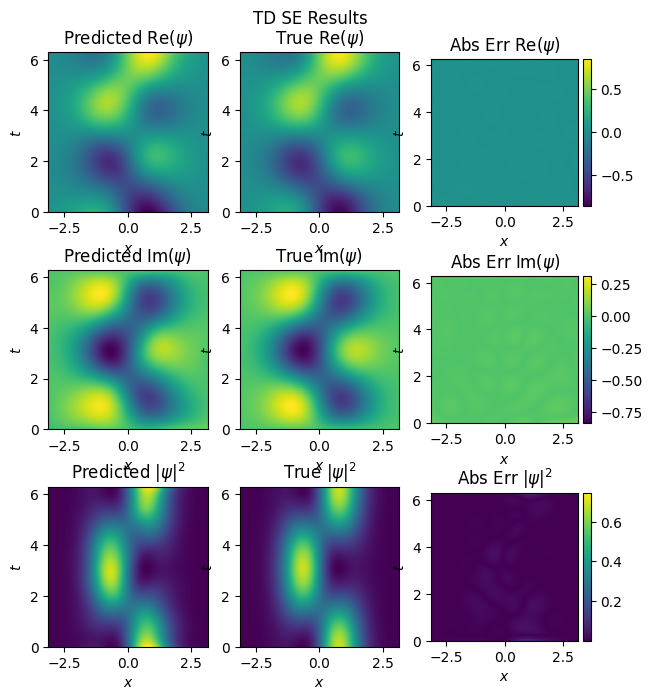

mse: u: 0.00010780865381379687, v:0.0001097763023899002


In [16]:
L = float(np.pi)
omega = 1
delta_T = 0.1
delta_X = 0.1
    
n_x = np.shape(np.arange(x_dom[0], x_dom[1], delta_X))[0]
n_t = np.shape(np.arange(t_dom[0], t_dom[1], delta_T))[0]

inference(model_nn, test_x, test_y, n_x, n_t, x_dom, t_dom, omega, 'nn')

Reading these snapshot plots: 
The first column consists of plots of neural network predictions The second column consists of true values and the last column is the Absolute Error between ground truth and predictions.

The rows are real($\psi$), imaginary($\psi$) and density $|\psi|^2$ .

In this case, since we used all the data over the domain for training, we get great results, where the NN approximates $\psi$ very well.

Now for a more realistic case. We might not have a lot of experimental data covering the entire domain of a system. To approximate that, let's train a neural network on a low resolution grid in a reduced domain $x \in [-\pi/4,\pi/4]$.

In [17]:
# Generate reduced training set
L = float(np.pi)
omega = 1

delta_T = 0.1
delta_X = 0.1
x_dom = [-L/4,L/4]
t_dom = [0, 2*L]

train_x, train_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_base)

We will test it's performance on a high resolution grid across the entire domain

In [18]:
delta_T = 0.01
delta_X = 0.01
x_dom = [-L,L]
t_dom = [0, 2*L]

test_x, test_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_base)

In [19]:

torch.manual_seed(314)
activation =  nn.Tanh()

model_nn = NN(2,2,20,3,activation).to(device)
n_epochs = 10000

    

In [20]:
%%time
model_nn, loss_list = train_nn(model_nn, n_epochs, train_x, train_y,)

Epoch 	 Loss
499 0.0280495968496817
999 0.00970774556381886
1499 0.002112161162151677
1999 0.001053235145540679
2499 0.00062376480607359
2999 0.0005511002498683486
3499 0.00034971716794948807
3999 0.0002717329363548327
4499 0.00022383319291693096
4999 0.00018512477227204834
5499 0.00015357521744514433
5999 0.0001282300100141558
6499 0.00010767243770961424
6999 9.093646157806822e-05
7499 9.035435865545592e-05
7999 0.00013094840082112781
8499 6.061885371411519e-05
8999 5.939190764896004e-05
9499 0.0003104107872182179
9999 4.5212132099977245e-05
CPU times: user 40.4 s, sys: 1min 44s, total: 2min 25s
Wall time: 15.3 s


So far so good, the training loss is small. But across the entire domain, the loss is:

In [21]:
y_pred = get_model_error(model_nn, test_x, test_y)

Model loss: 
 loss_u = 0.27965103078296966 
 loss_v = 0.4789366338565432 
 loss_dens = 3.7312397212669066


The error is orders of magnitude higher than our data point values! Let's look at the plots:


0 finished
1 finished
2 finished


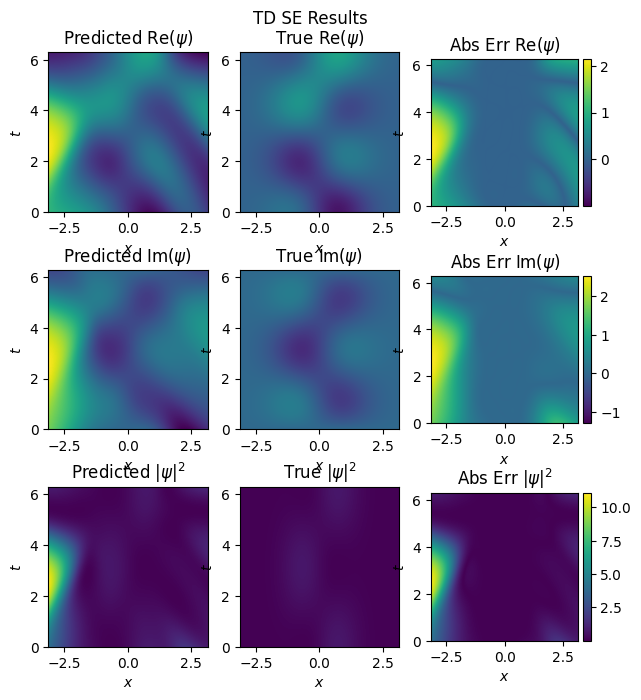

mse: u: 0.2796510307829696, v:0.47893663385654334


In [22]:
L = float(np.pi)
omega = 1
delta_T = 0.01
delta_X = 0.01
    
n_x = np.shape(np.arange(x_dom[0], x_dom[1], delta_X))[0]
n_t = np.shape(np.arange(t_dom[0], t_dom[1], delta_T))[0]

inference(model_nn, test_x, test_y, n_x, n_t, x_dom, t_dom, omega, 'nn_reduced')

The values are similar in the domain that we trained on $x \in [-0.78,0.78]$ but diverge considerably near the boundaries.

To tackle this problem, we will add some information about the governing equation in the neural network.

### <span style="color:LightGreen">Physics-Informed Neural Network

Physics Informed Neural Networks are constructed by encoding the constraints posed by a given differential equation and its boundary conditions into the loss function of a Fully Connected Network. This constraint guides the network to approximate the solution of the differential equation.

For a system $f$, with solution $u(\mathbf{x},t)$, governed by the following equation

$$ \Large
f(u) = u_{t}+\mathcal{N}[u;\lambda], ~~~\mathbf{x} \in \Omega, t \in [0,T] \\
f(u) = 0 ~~~~~~~~~~~~~ \rm{otherwise}
$$

where $\mathcal{N}[u;\lambda]$ is a differential operator parameterised by $ \lambda $, $ \Omega \in \mathbb{R^D} $, $ \mathbf{x} = (x_1,x_2,...,x_d) $ with boundary conditions 

$$ \Large
\mathcal{B}(u, \mathbf{x},t)=0 \quad \text { on } \quad \partial \Omega
$$

and initial conditions

$$ \Large
\mathcal{T}(u, \mathbf{x},t)=0 \quad \text { at } \quad t = 0
$$

![PINN architecture](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/res/fig/PINN_diagrams.png?raw=1)

A neural network $u_{net}: \mathbb{R}^{D+1}\mapsto \mathbb{R}^{1}$ is constructed as a surrogate model for the true solution $u$, 

$$ \Large
f_{net}=f(u_{net})
$$

The constraints imposed by the system are encoded in the loss term $L$ for neural network optimisation

$$ \Large
L={\color{green} L_{f}}+{\color{red} L_{BC}}+{\color{blue} L_{IC}}
$$

where $L_{f}$ denotes the error in the solution within the interior points of the system, enforcing the PDE. This error is calculated for $N_f$ collocation points.

$$ \Large
\color{green} 
L_{f}=\frac{1}{N_{f}} \sum_{i=1}^{N_{f}}\left|f_{net}\left(\mathbf{x}_{f}^{i}, t_{f}^{i}\right)\right|^{2}
$$

$$ \Large
\color{red} 
L_{BC}=\frac{1}{N_{BC}} \sum_{i=1}^{N_{BC}}\left|u\left(\mathbf{x}_{BC}^{i}, t_{BC}^{i}\right)-u^{i}\right|^{2}
$$

$$ \Large
\color{blue} 
L_{IC}=\frac{1}{N_{IC}} \sum_{i=1}^{N_{IC}}\left|u\left(\mathbf{x}_{IC}^{i}, t_{IC}^{i}\right)-u^{i}\right|^{2}
$$

$L_{BC}$ and $L_{IC}$ represent the constraints imposed by the boundary and initial conditions, calculated on a set of $N_{BC}$ boundary points and $N_{IC}$ initial points respectively, with $u_i$ being the ground truth.

<img src="https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/res/fig/colloc_points.png?raw=1" alt="Domain" width="400"/>

Once sufficiently trained, the network can be used as a solver for the PDE, potentially for a range of parameters $ \lambda $.


Since PINNs can be used to solve systems of arbitrary resolutions once they are trained and generalise well over different parameter spaces, they might be used to accelerate the solution of PDEs. 

The following function creates the collocation points for the equation, boundary and initial conditions.



In [23]:
def get_physics_colloc_points(x_dom, t_dom, delta_X, delta_T,analytical_solution_function):

    x = np.arange(x_dom[0], x_dom[1], delta_X).astype(float)
    t = np.arange(t_dom[0], t_dom[1], delta_T).astype(float)
    X, T = np.meshgrid(x, t)
    
    x_physics = np.expand_dims(X.flatten(), axis=-1)
    t_physics = np.expand_dims(T.flatten(), axis=-1)

    x_physics = torch.tensor(x_physics).requires_grad_(True).to(device)
    t_physics = torch.tensor(t_physics).requires_grad_(True).to(device)

    f_colloc = torch.hstack((x_physics, t_physics)).to(device)
    
    t_ic = np.zeros_like(x)
    X_ic, T_ic = np.meshgrid(x, t_ic)
    
    x_ic = np.expand_dims(X_ic.flatten(), axis=-1)
    t_ic = np.expand_dims(T_ic.flatten(), axis=-1)
    
    ic_sol = analytical_solution_function(x_ic,t_ic, omega)
    ic = np.hstack((np.real(ic_sol), np.imag(ic_sol)))
    
    ic = torch.tensor(ic).requires_grad_(False).to(device)
    
    x_ic = torch.tensor(x_ic).requires_grad_(False).to(device)
    t_ic = torch.tensor(t_ic).requires_grad_(False).to(device)

    ic_colloc = torch.hstack((x_ic, t_ic))
    
    x_b = np.array(x_dom)
    X_b, T_b = np.meshgrid(x_b, t)
    x_b = np.expand_dims(X_b.flatten(), axis=-1)
    t_b = np.expand_dims(T_b.flatten(), axis=-1)

    x_b = torch.tensor(x_b).requires_grad_(False).to(device)
    t_b = torch.tensor(t_b).requires_grad_(False).to(device)

    b_colloc = torch.hstack((x_b, t_b))
    
    return x_physics, t_physics,f_colloc, b_colloc, ic_colloc, ic

omega = 1
x_dom = [-L,L]
t_dom = [0,2*L]
delta_x = 0.2
delta_t = 0.2
analytical_solution_function = get_analytical_solution_base
x_physics, t_physics, f_colloc, b_colloc, ic_colloc, ic = get_physics_colloc_points(x_dom, t_dom, delta_x, delta_t, analytical_solution_function)

___<span style="color:Violet">Exercise</span>___: What will the loss terms look like in this case? Hint: Split the Schrodinger equation in real and imaginary parts to calculate the equation loss.

Solution: The time-dependent Schrödinger equation can be written as

$$ \Large
    \left(-\frac{\partial v}{\partial t}+\frac{1}{2}\frac{\partial^{2} u}{\partial x^{2}}-\frac{\omega^{2}}{2}x^{2}\right) + i \left(\frac{\partial u}{\partial t}+\frac{1}{2}\frac{\partial^{2} v}{\partial x^{2}}-\frac{\omega^{2}}{2}x^{2}\right) = 0
$$

The loss function $L$ is given by 

$$ \Large
L=L_{f}+L_{BC}+L_{IC}
$$

$$ \Large
L_{BC}=\frac{1}{N_{BC}} \sum_{i=1}^{N_{BC}}\left(\left|u\left(\mathbf{r}_{BC}^{i}, t_{BC}^{i}\right)-u^{i}\right|^{2}+\left|v\left(\mathbf{r}_{BC}^{i}, t_{BC}^{i}\right)-v^{i}\right|^{2}\right)
$$

$$ \Large
L_{IC}=\frac{1}{N_{IC}} \sum_{i=1}^{N_{IC}}\left(\left|v\left(\mathbf{r}_{IC}^{i}, t_{IC}^{i}\right)-u^{i}\right|^{2}+\left|v\left(\mathbf{r}_{IC}^{i}, t_{IC}^{i}\right)-v^{i}\right|^{2}\right)
$$

$$ \Large
L_{f}=\frac{1}{N_{f}} \sum_{i=1}^{N_{f}}\left|f_{net}\left(\mathbf{r}_{f}^{i}, t_{f}^{i}\right)\right|^{2}
$$

At each training step, the loss function is calculated on $N_f$ collocation points, sampled randomly from the grid.

We need to modify the training loop to calculate the new physics informed loss function:

In [24]:
def train_pinn(model, n_epochs, train_x, train_y, x_physics, t_physics, f_colloc, b_colloc, ic_colloc, ic):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
    loss_list = np.zeros(n_epochs)
    print("Epoch \t Loss \t PDE Loss")
    for i in range(n_epochs):
        optimizer.zero_grad()
        y_pred = model(train_x)

        loss1 = torch.mean((y_pred-train_y)**2)

        # calculate loss on colloc points

        y_pred = model(f_colloc)

        u = y_pred[:,0]
        v = y_pred[:,1]

        du_dx  = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
        du_dxx  = torch.autograd.grad(du_dx, x_physics, torch.ones_like(du_dx), create_graph=True)[0]
        du_dt = torch.autograd.grad(u,  t_physics, torch.ones_like(y_pred[:,0]),  create_graph=True)[0]
        if debug:
            print("flag_2")
        dv_dx  = torch.autograd.grad(v, x_physics, torch.ones_like(v), create_graph=True)[0]
        dv_dxx  = torch.autograd.grad(dv_dx, x_physics, torch.ones_like(dv_dx), create_graph=True)[0]
        dv_dt = torch.autograd.grad(v,  t_physics, torch.ones_like(v),  create_graph=True)[0]
        if debug:
            print("flag_3")
        loss_u = -du_dt - 1/2 * (dv_dxx + omega**2/2 * x_physics**2) * v.view(-1,1)
        loss_v = -dv_dt + 1/2 * (du_dxx + omega**2/2 * x_physics**2) * u.view(-1,1)

        loss_physics = torch.stack((loss_u, loss_v))
        if debug:
            print("flag_4")
        y_pred_b = model(b_colloc)
        y_pred_ic = model(ic_colloc)
        if debug:
            print("flag_5")
        loss_b = torch.mean(y_pred_b**2)
        loss_ic = torch.mean((y_pred_ic - ic)**2)

        loss2 =  (torch.mean(loss_physics**2) + loss_b + loss_ic)
        if debug:
            print("flag_6")
        

        loss = loss1 + (1e-4) * loss2# add two loss terms together
        loss_list[i] = loss.detach().cpu().numpy()

        loss.backward()
        optimizer.step()
        if debug:
            print("flag_7")
        if i % 500 == 499:
            print(f"{i} {loss} {loss2}")
    
    return model, loss_list

We will now train the PINN on the same reduced domain

In [25]:

debug = False
torch.manual_seed(123)
activation =  nn.Tanh()

n_epochs = 10000
model_pinn = NN(2,2,32,3,activation).to(device)
model_pinn, loss_pinn = train_pinn(model_pinn, n_epochs, train_x, train_y, x_physics, t_physics, f_colloc, b_colloc, ic_colloc, ic)

Epoch 	 Loss 	 PDE Loss
499 0.014588414251169447 0.5443244929559574
999 0.002057909498909604 0.47980876854626764
1499 0.000752848210323483 0.32130906985982965
1999 0.00038905896832055033 0.27477670389725717
2499 0.00023619857124865522 0.2569463220926042
2999 0.00016144592230288353 0.24845951574050348
3499 0.00012984662518829 0.24287173665549008
3999 0.00010369403498301003 0.23644538989070582
4499 0.00024421748826510475 0.22650578439472405
4999 6.91502544887959e-05 0.22112804882397236
5499 5.956635663430923e-05 0.21487782727285187
5999 6.120328859927873e-05 0.20864176537291124
6499 6.703809883297787e-05 0.20516927845997324
6999 4.959094562971646e-05 0.2004047747429418
7499 4.485902265233991e-05 0.19725223358535046
7999 4.121315201116807e-05 0.1950604839212145
8499 4.5979261473473666e-05 0.19243319802737877
8999 4.376134743028516e-05 0.19118845060161438
9499 0.00014841181263101314 0.18968439510832458
9999 3.413877395732105e-05 0.18695250866956242


In [26]:
y_pred = get_model_error(model_pinn, test_x, test_y)

Model loss: 
 loss_u = 0.005162967027706011 
 loss_v = 0.004233931075173614 
 loss_dens = 0.001085378939832916


0 finished
1 finished
2 finished


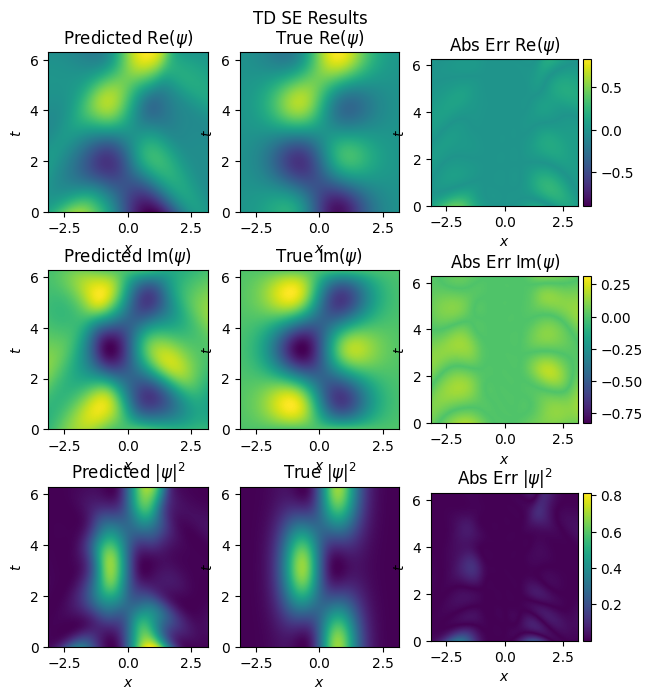

mse: u: 0.005162967027706011, v:0.004233931075173614


In [27]:
L = float(np.pi)
omega = 1
delta_T = 0.01
delta_X = 0.01
    
n_x = np.shape(np.arange(x_dom[0], x_dom[1], delta_X))[0]
n_t = np.shape(np.arange(t_dom[0], t_dom[1], delta_T))[0]

inference(model_pinn, test_x, test_y, n_x, n_t, x_dom, t_dom, omega, 'pinn_reduced')

The PINN model matches the system well, even when trained on reduced data.

#### <span style="color:Orange">Training Considerations</span>

##### <span style="color:Violet">Architecture</span>

The architecture and associated hyperparameters have significant impact on the performance of the PINN. The learning model architecture can be customized depending on the nature of the domain. For example, CNNs, RNNs and GNNs can be used for spatial, temporal and interacting problems respectively. For the one-dimensional quantum harmonic oscillator workflow, we use a FCN with 3 layers of 20 neurons each. 

Optimizer selection is important for convergence of the learner and to avoid solutions at local minima. It has been shown that a combination of Adam  at early training and L-BFGS for later stages has been effective for solving a variety of PDEs through PINNs. We use the Adam optimizer only given the relatively simple nature of this problem.

___<span style="color:Violet">Exercise</span>___: Try running the PINN with ReLU activation function. What are your observations? Why would this activation function not work?

Solution: As we saw in calculating the residual, the choice of activation functions is constrained by the fact that they have to be $(n+1)$-differentiable for $n$-order PDEs. For the one-dimensional quantum harmonic oscillator problem we use $\tanh$ activation functions because they are 3-differentiable.

##### <span style="color:Violet">Collection Points</span>


The accuracy of the NN increases with increase in density of collocation points. However, the computational resources required also increases exponentially with the increase in density of points. This can lead to training bottlenecks, especially for high dimensional systems. A trade-off has to be made between the desired accuracy and number of collocation points because training the NN on a large number of points may lead to overfitting and adversely affect generalisability. The distribution of points can also be customised according to the problem domain. Density could be increased around areas of sharp discontinuities to capture more information about the domain. 

___<span style="color:Violet">Exercise</span>___: What is the effect of changing collocation points on the training time and accuracy of the Neural Network? You can run it multiple times with different grids of collocation point to observe this.

Solution

Training time and accuracy both increase exponentially with collocation grid size.

<img src="https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/main/Learning_the_Schrodinger_Equation/res/fig/pinn_colloc_time.png" alt="Domain" width="300"/>

<img src="https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/main/Learning_the_Schrodinger_Equation/res/fig/pinn_colloc_performance.png" alt="Domain" width="300"/>

---


## <span style="color:Orange">Higher Energy States</span>

We will now check the performance of NNs on systems with higher energy states. For demonstration, the system used is $\psi_{1,3}(x,t)$.  The analytic solution is implemented in the method below (I will leave it to you to derive it)

let's write some code to compute it for arbitrary values of $x,t,\omega$

In [28]:
def get_analytical_solution_1_3(X,T, omega):
    #Solution:
    phi_0 =(omega / np.pi) ** (1. / 4.) * np.exp(-X * omega * X / 2.0)
    phi_1 = phi_0 *  np.sqrt(omega / 2.) * 2.0 * X
    phi_3 = phi_0 * 1/np.sqrt(48) * (8. * omega**(3./2.) * X**3. - 12. * omega**(1./2.) * X)
    psi = np.sqrt(1. / 2.) * (np.exp(-1j * 3./2. * omega * T) * phi_1 + np.exp(-1j * 7./2. * omega * T) * phi_3)

    return psi

You can explore the system here:

<img src="https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/res/plots/waveform/psi_1_3/animation.gif?raw=true" width=800 align=left></img><br>

Using a reduced grid with Fully Connected Network, we have

In [29]:
L = float(np.pi)
omega = 1

delta_T = 0.1
delta_X = 0.1
x_dom = [-L/4,L/4]
t_dom = [0, 2*L]

train_x, train_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_1_3)

In [30]:
delta_T = 0.01
delta_X = 0.01
x_dom = [-L,L]
t_dom = [0, 2*L]

test_x, test_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_1_3)

In [31]:


torch.manual_seed(314)
activation =  nn.Tanh()

model_nn_he = NN(2,2,32,3,activation).to(device)
optimizer = torch.optim.Adam(model_nn_he.parameters(),lr=1e-3)

n_epochs = 10000

In [32]:
%%time
model_nn_he, loss_list = train_nn(model_nn_he, n_epochs, train_x, train_y)
    

Epoch 	 Loss
499 0.034809466822957144
999 0.030763050923567896
1499 0.02905167696835714
1999 0.027556365625694575
2499 0.024719659586685996
2999 0.01903259061624242
3499 0.016080742515342025
3999 0.013575941799995562
4499 0.008327805548276605
4999 0.004173534335946348
5499 0.0028336940608312245
5999 0.0021108187074974968
6499 0.0016050445783580606
6999 0.0012372479567378436
7499 0.0009793754786020712
7999 0.0008145275548909968
8499 0.000715745373919582
8999 0.0006201187354938758
9499 0.0005582432452525086
9999 0.0006281879257915837
CPU times: user 1min, sys: 2min 7s, total: 3min 7s
Wall time: 18 s


In [33]:
y_pred = get_model_error(model_nn_he, test_x, test_y)

Model loss: 
 loss_u = 0.21393157014380676 
 loss_v = 0.3248373316806696 
 loss_dens = 1.1822764235926622


0 finished
1 finished
2 finished


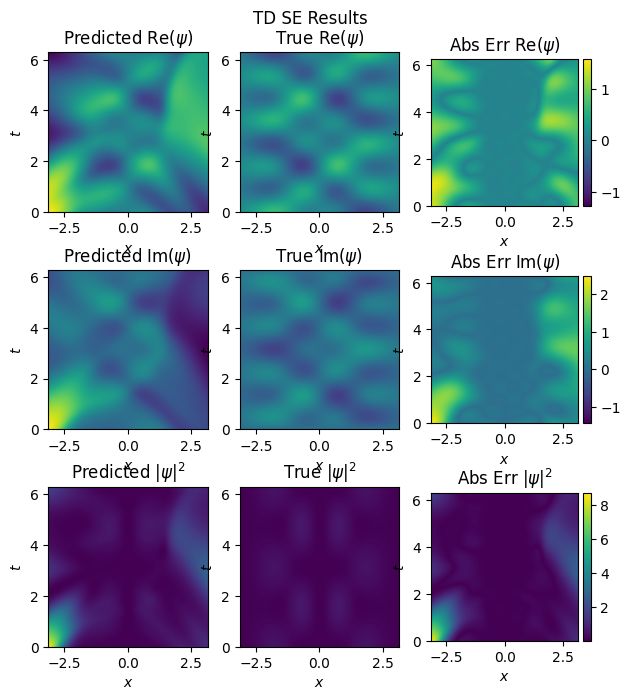

mse: u: 0.21393157014380676, v:0.3248373316806697


In [34]:
L = float(np.pi)
omega = 1
delta_T = 0.01
delta_X = 0.01
    
n_x = np.shape(np.arange(x_dom[0], x_dom[1], delta_X))[0]
n_t = np.shape(np.arange(t_dom[0], t_dom[1], delta_T))[0]

inference(model_nn_he, test_x, test_y, n_x, n_t, x_dom, t_dom, omega, 'high_nn')

This does not capture any detail beyond the domain, as seen in Abs Err plots. Now for PINNs:

In [35]:
omega = 1
x_dom = [-L,L]
t_dom = [0,2*L]
delta_x = 0.2
delta_t = 0.2
analytical_solution_function = get_analytical_solution_1_3
x_physics, t_physics, f_colloc, b_colloc, ic_colloc, ic = get_physics_colloc_points(x_dom, t_dom, delta_x, delta_t, analytical_solution_function)

In [36]:
debug = False
torch.manual_seed(314)
activation =  nn.Tanh()

n_epochs = 10000
model_pinn_he = NN(2,2,32,3,activation).to(device)



In [37]:
model_pinn_he, loss_pinn = train_pinn(model_pinn_he, n_epochs, train_x, train_y, x_physics, t_physics, f_colloc, b_colloc, ic_colloc, ic)

Epoch 	 Loss 	 PDE Loss
499 0.03480288126139388 1.166716632588837
999 0.031055946460958134 0.8942701610393845
1499 0.0290274898286505 0.7786032447054414
1999 0.027261077327968942 0.7137444686917981
2499 0.02345051515528289 0.6624213151863514
2999 0.0177163142938211 0.7761359625227194
3499 0.014716462942900018 0.8349283089219759
3999 0.01144803168221269 0.9774179441385227
4499 0.005641550844731831 1.112667247170992
4999 0.003663552520883993 1.158246987266214
5499 0.002457872967877604 1.1752925633070639
5999 0.0018889908408054698 1.0818735274821583
6499 0.0014706641801068246 0.9184216946517176
6999 0.0011908249581626586 0.7823150778428927
7499 0.0010005241538707426 0.7108240373438278
7999 0.0008434707660658345 0.6695406492316499
8499 0.0007130773858100163 0.626987277307156
8999 0.0006134526595682283 0.599202329957043
9499 0.0005355375288372476 0.573277127375645
9999 0.0004761384659730534 0.5431425660957278


In [38]:
y_pred = get_model_error(model_pinn_he, test_x, test_y)

Model loss: 
 loss_u = 0.07508103102250276 
 loss_v = 0.04283791400676694 
 loss_dens = 0.011924277495947893


In [39]:
L = float(np.pi)
omega = 1
delta_T = 0.01
delta_X = 0.01
    
n_x = np.shape(np.arange(x_dom[0], x_dom[1], delta_X))[0]
n_t = np.shape(np.arange(t_dom[0], t_dom[1], delta_T))[0]
test_x, test_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_1_3)

0 finished
1 finished
2 finished


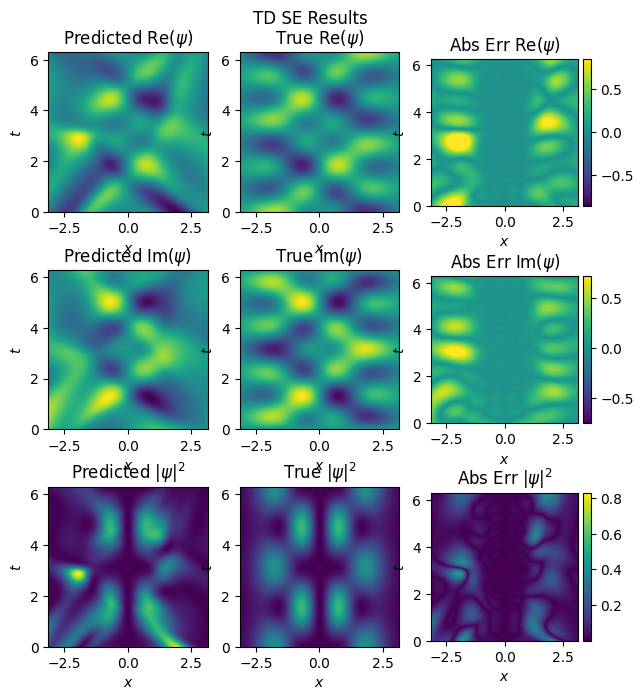

mse: u: 0.07508103102250274, v:0.04283791400676694


In [40]:
inference(model_pinn_he, test_x, test_y, n_x, n_t, x_dom, t_dom, omega, 'high_pinn')

For higher energy states, it is difficult to capture the details with fully connected layers. PINNs can be extended with Recurrent Neural Networks to tackle this.

## <span style="color:Orange">Some Project Ideas</span>

1. Experiment with different layer types for the higher energy states. One particular layer that might be useful would be gru layer (https://pytorch.org/docs/stable/generated/torch.nn.GRU.html). These layers are used for time series forecasting in Recurrent Neural Networks, which might be helpful for our time dependent system.

2. You can also use causal training loss for the higer energy states. The loss we have been using so far does not take causality into account. For a causal loss function, we divide the domain into consecutive time chunks and use a weighted sum of losses that enforces order in time. You can read more about it here: 

2. Modify the PINNs to work with 2D QHO system
Hint: Since this is a separable system, we can extend it to 2D as follow:
$$ \Large
\phi_n = \phi_n(x)\phi_n(y)
$$

$$ \Large
\hat{H} =\hat{H_x}+\hat{H_y}
$$

3. Can the neural network generalize over other parameters as well? Add $\omega$ as an input to the neural network and train it to work with a range of $\omega$ values.

4. Implement this network for other systems such as infinite square well.

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer
  * From APS GDS repository

© Copyright 2025